# <center> Explainability in RecSys </center>

В прошлый раз мы поработали с графами, а в этот - построим граф знаний и посмотрим на примеры того, как можно получать обяъяснения рекомендаций, в том числе и более простые техники.

[Hu, Y., Koren, Y. and Volinsky, C., 2008, December. Collaborative filtering for implicit feedback datasets. In 2008 Eighth IEEE international conference on data mining (pp. 263-272). Ieee.](http://yifanhu.net/PUB/cf.pdf)

In [1]:
import gzip
from implicit.als import AlternatingLeastSquares
from implicit.datasets.lastfm import get_lastfm
from implicit.nearest_neighbours import bm25_weight
import pandas as pd
import shutil
import warnings
warnings.filterwarnings("ignore")

from knowledge_graph_utils import propagate_item_removal_to_kg

artists, users, artist_user_plays = get_lastfm()

Взвешивание матрицы, что снизить эффекты популярных музыкальных композиций и слишком активных пользователей. Транспонируем, т.к. на вход подаются  (user, item) матрицы

In [ ]:
artist_user_plays = bm25_weight(artist_user_plays, K1=100, B=0.8)

user_plays = artist_user_plays.T.tocsr()

model = AlternatingLeastSquares(factors=16, regularization=0.05)
model.fit(artist_user_plays.T.tocsr())

  0%|          | 0/15 [00:00<?, ?it/s]

In [ ]:
userid = 12345
model.recommend(userid, user_plays[userid], N=10, filter_already_liked_items=False)
model.explain(userid, user_items, itemid, user_weights=None, N=10)

Но можно пробовать использовать более сложные подходы, например, через KG.

Вспомним, что граф знаний состоит из сущностей (entity head, entity tail) и отношений между ними (relations). Вот, пример такого графа: 

<img src='https://d3i71xaburhd42.cloudfront.net/76da7eab258081c257ebd87f7a559d44e31d8315/1-Figure1-1.png' width=600>

Считаем датасет, состоящий из 3 файлов:

In [2]:
ml1m_path = 'data/ml1m'
ml1m_users_df = pd.read_csv(f'{ml1m_path}/users.dat', 
                            sep="::", 
                            names=["UserID","Gender","Age","Occupation","Zip-code"], 
                            header=None)
display(ml1m_users_df.head())

ml1m_movies_df = pd.read_csv(f'{ml1m_path}/movies.dat', 
                             sep="::", 
                             names=["movie_id", "movie_name", "genre"], 
                             header=None, 
                             encoding='latin-1')
display(ml1m_movies_df.head())

ml1m_ratings_df = pd.read_csv(f'{ml1m_path}/ratings.dat', 
                              sep="::", 
                              names=["user_id", "movie_id", "rating", "timestamp"], 
                              header=None)
ml1m_ratings_df.head()

UserID Gender  Age  Occupation Zip-code
0       1      F    1          10    48067
1       2      M   56          16    70072
2       3      M   25          15    55117
3       4      M   45           7    02460
4       5      M   25          20    55455

movie_id                          movie_name                         genre
0         1                    Toy Story (1995)   Animation|Children's|Comedy
1         2                      Jumanji (1995)  Adventure|Children's|Fantasy
2         3             Grumpier Old Men (1995)                Comedy|Romance
3         4            Waiting to Exhale (1995)                  Comedy|Drama
4         5  Father of the Bride Part II (1995)                        Comedy

user_id  movie_id  rating  timestamp
0        1      1193       5  978300760
1        1       661       3  978302109
2        1       914       3  978301968
3        1      3408       4  978300275
4        1      2355       5  978824291

In [3]:
print(f"Unique Users: {ml1m_users_df.UserID.nunique()}")
print(f"Unique Products: {ml1m_movies_df.movie_id.nunique()}")
print(f"Interactions: {len(ml1m_ratings_df)}")

Unique Users: 6040
Unique Products: 3883
Interactions: 1000209


Построим граф знаний с помощью DBpedia KG, состоящей из 4 файлов:

- `i2kg_map.tsv`: соотнесение MovieLens-1M датасета с соответствующей вершиной в графе знаний.

- `e_map.dat`: множество сущностей

- `r_map.dat`: множество отношений

- `kg.dat`: множество триплетов *(entity_head, relation, entity_tail)*.

URL-адрес сущности ведет на страницу объекта в базе знаний DBpedia, где можно узнать больше о нем и о том, каковы его отношения с другими объектами.

In [4]:
%cd /home/m.ananyeva/recsys_course/week7

entities_df = pd.read_csv(f'{ml1m_path}/kg/e_map.dat', sep="\t", names=["entity_id", "entity_url"])
display(entities_df.head())

movies_to_kg_df = pd.read_csv(f'{ml1m_path}/kg/i2kg_map.tsv', 
                              sep="\t", 
                              names=["dataset_id", "movie_name", "entity_url"])
display(movies_to_kg_df.head())
print(f"Items mapped in the KG: {movies_to_kg_df.shape[0]}")

kg_df = pd.read_csv(f'{ml1m_path}/kg/kg.dat', sep="\t")
display(kg_df.head())

relations_df = pd.read_csv(f'{ml1m_path}/kg/r_map.dat', sep="\t", names=["relation_id", "relation_url"])
relations_df.head()

/home/m.ananyeva/recsys_course/week7


entity_id                                         entity_url
0          0            http://dbpedia.org/resource/Roger_Carel
1          1       http://dbpedia.org/resource/Soundtrack_album
2          2           http://dbpedia.org/resource/1982_in_film
3          3  http://dbpedia.org/resource/Category:Films_set...
4          4            http://dbpedia.org/resource/Plaza_Hotel

dataset_id                movie_name  \
0         781    Stealing Beauty (1996)   
1        1799      Suicide Kings (1997)   
2         521  Romeo Is Bleeding (1993)   
3        3596            Screwed (2000)   
4        3682       Magnum Force (1973)   

                                        entity_url  
0      http://dbpedia.org/resource/Stealing_Beauty  
1        http://dbpedia.org/resource/Suicide_Kings  
2    http://dbpedia.org/resource/Romeo_Is_Bleeding  
3  http://dbpedia.org/resource/Screwed_(2000_film)  
4         http://dbpedia.org/resource/Magnum_Force

Items mapped in the KG: 3301


entity_head  entity_tail  relation
0         9386         4955        12
1         6851         1770         1
2          210         5210         8
3         4205          406        12
4        11533        12345         3

relation_id                                     relation_url
0            0       http://dbpedia.org/ontology/cinematography
1            1  http://dbpedia.org/property/productionCompanies
2            2             http://dbpedia.org/property/composer
3            3                 http://purl.org/dc/terms/subject
4            4          http://dbpedia.org/ontology/openingFilm

### Preprocessing

In [5]:
print(f"Items in the dataset: {ml1m_movies_df.shape[0]}")
print(f"Items correctly mapped in KG: {movies_to_kg_df.shape[0]}")
# print(f"Number of triplets: {kg_df.shape[0]}")

Items in the dataset: 3883
Items correctly mapped in KG: 3301


In [6]:
number_of_movies = ml1m_movies_df.movie_id.nunique()
ml1m_movies_df = ml1m_movies_df[ml1m_movies_df['movie_id'].isin(movies_to_kg_df.dataset_id)]
ml1m_movies_df.reset_index()
display(ml1m_movies_df.head(5))
print(f"The number of rows removed due to missing links with KG: {number_of_movies - ml1m_movies_df.shape[0]}")

movie_id                          movie_name                         genre
1         2                      Jumanji (1995)  Adventure|Children's|Fantasy
2         3             Grumpier Old Men (1995)                Comedy|Romance
3         4            Waiting to Exhale (1995)                  Comedy|Drama
4         5  Father of the Bride Part II (1995)                        Comedy
5         6                         Heat (1995)         Action|Crime|Thriller

The number of rows removed due to missing links with KG: 582


In [7]:
movies_to_kg_df = pd.merge(movies_to_kg_df, entities_df, on=["entity_url"])
display(movies_to_kg_df.head(5))
print(f"Correctly mapped items: {movies_to_kg_df.shape[0]}")

dataset_id                movie_name  \
0         781    Stealing Beauty (1996)   
1        1799      Suicide Kings (1997)   
2         521  Romeo Is Bleeding (1993)   
3        3596            Screwed (2000)   
4        3682       Magnum Force (1973)   

                                        entity_url  entity_id  
0      http://dbpedia.org/resource/Stealing_Beauty       5474  
1        http://dbpedia.org/resource/Suicide_Kings       9337  
2    http://dbpedia.org/resource/Romeo_Is_Bleeding       8520  
3  http://dbpedia.org/resource/Screwed_(2000_film)       4713  
4         http://dbpedia.org/resource/Magnum_Force      14676

Correctly mapped items: 3266


In [8]:
movies_to_kg_df = movies_to_kg_df[movies_to_kg_df.entity_id.isin(entities_df.entity_id)]
number_of_ratings = ml1m_ratings_df.shape[0]
ml1m_ratings_df = ml1m_ratings_df[ml1m_ratings_df['movie_id'].isin(movies_to_kg_df.dataset_id)]
ml1m_ratings_df.reset_index()
display(ml1m_ratings_df.head(5))
print(f"The number of rows removed due to removed movies: {number_of_ratings - ml1m_ratings_df.shape[0]}")

user_id  movie_id  rating  timestamp
0        1      1193       5  978300760
1        1       661       3  978302109
2        1       914       3  978301968
3        1      3408       4  978300275
4        1      2355       5  978824291

The number of rows removed due to removed movies: 58904


2. Фильтрация датасета до k-core.

In [9]:
k_user, k_movie = 5, 5
counts_col_user = ml1m_ratings_df.groupby("user_id")["user_id"].transform(len)
counts_col_movies = ml1m_ratings_df.groupby("movie_id")["movie_id"].transform(len)

mask_user = counts_col_user >= k_user
mask_movies = counts_col_movies >= k_movie
ml1m_ratings_df = ml1m_ratings_df[mask_user & mask_movies]
ml1m_users_df = ml1m_users_df[ml1m_users_df.UserID.isin(ml1m_ratings_df.user_id.unique())]
ml1m_movies_df = ml1m_movies_df[ml1m_movies_df.movie_id.isin(ml1m_ratings_df.movie_id.unique())]

In [10]:
movies_to_kg_df, entities_df, kg_df = propagate_item_removal_to_kg(ml1m_movies_df, 
                                                                   movies_to_kg_df, 
                                                                   entities_df, 
                                                                   kg_df)

Removed 236 entries from i2kg map.
Removed 236 entries from e_map
Removed 11916 triplets from kg_df


3. Сохраним датасет в нужном формате

In [11]:
ml1m_preprocessed_path = 'data/ml1m/preprocessed'

# Delete extra columns
ml1m_users_df = ml1m_users_df.drop(["Gender", "Age", "Occupation", "Zip-code"], axis=1)

# Add new ids
ml1m_users_df.insert(0, 'new_id', range(ml1m_users_df.shape[0]))

# Save
ml1m_users_df.to_csv(f'{ml1m_preprocessed_path}/users.txt', header=["new_id", "raw_dataset_id"], index=False, sep='\t', mode='w+')
user_id2new_id = dict(zip(ml1m_users_df["UserID"], ml1m_users_df.new_id))

То же самое для файлов с фильмами и рейтингами.

In [12]:
ml1m_movies_df = ml1m_movies_df.drop(["movie_name", "genre"], axis=1)
ml1m_movies_df.insert(0, 'new_id', range(ml1m_movies_df.shape[0]))
ml1m_movies_df.to_csv(f'{ml1m_preprocessed_path}/products.txt', 
                      header=["new_id", "raw_dataset_id"], 
                      index=False, 
                      sep='\t', 
                      mode='w+')
movie_id2new_id = dict(zip(ml1m_movies_df["movie_id"], ml1m_movies_df.new_id))

In [13]:
ml1m_ratings_df["user_id"] = ml1m_ratings_df['user_id'].map(user_id2new_id)
ml1m_ratings_df["movie_id"] = ml1m_ratings_df['movie_id'].map(movie_id2new_id)
ml1m_ratings_df.to_csv(f'{ml1m_preprocessed_path}/ratings.txt', 
                       header=["uid", "pid", "rating", "timestamp"], 
                       index=False, 
                       sep='\t', 
                       mode='w+')

4. Почистим тройки графа.

- Сущность (entity head) **должна быть** фильмом (в `movies_to_kg_df`)
- Сущность (entity tail) **не должна быть** фильмом (в `movies_to_kg_df`)

In [14]:
mask = kg_df['entity_tail'].isin(movies_to_kg_df.entity_id) & ~kg_df['entity_head'].isin(movies_to_kg_df.entity_id)
kg_df.loc[mask, ['entity_head', 'entity_tail']] = (kg_df.loc[mask, ['entity_tail', 'entity_head']].values)

n_of_triplets = kg_df.shape[0]
kg_df = kg_df[(kg_df['entity_head'].isin(movies_to_kg_df.entity_id) & ~kg_df['entity_tail'].isin(movies_to_kg_df.entity_id))]
display(kg_df.head(5))
print(f"The number of triplets before: {n_of_triplets}")
print(f"The number of triplets after: {kg_df.shape[0]}")

entity_head  entity_tail  relation
0         9386         4955        12
1         6851         1770         1
2          210         5210         8
3         4205          406        12
4        11533        12345         3

The number of triplets before: 422273
The number of triplets after: 409887


Исходно, у нас было 20 уникальных типов отношений. Можно проверить, потеряли ли мы какие-то из них:

In [15]:
len(kg_df.relation.unique())

20

5. Мы можем сделать более плотный граф, по аналогии с k-core

In [21]:
v = kg_df[['relation']]
n_of_triplets = kg_df.shape[0]
kg_df = kg_df[v.replace(v.apply(pd.Series.value_counts)).gt(300).all(1)]
print(f"Number of triplets before: {n_of_triplets}")
print(f"Number of triplets after: {kg_df.shape[0]}")
print(f"The number of left relations in a graph: {kg_df.relation.nunique()}")

# Update relations as well due to deleted triplets
relations_df = relations_df[relations_df['relation_id'].isin(kg_df.relation.unique())]
relations_df.reset_index()

Number of triplets before: 409477
Number of triplets after: 409477
The number of left relations in a graph: 13


In [24]:
relations_df = relations_df[(relations_df['relation_id'] != 13) & (relations_df['relation_id'] != 8)]
kg_df = kg_df[kg_df.relation.isin(relations_df.relation_id)]
entities_df = entities_df[entities_df.entity_id.isin(kg_df.entity_head) | entities_df.entity_id.isin(kg_df.entity_tail)]

In [25]:
ml1m_kg_preprocessed_path = 'data/ml1m/preprocessed/'

relations_df.to_csv(f'{ml1m_kg_preprocessed_path}/r_map.txt', 
                    header=["relation_id", "relation_url"], 
                    index=False, 
                    sep='\t', 
                    mode='w+')

entities_df.to_csv(f'{ml1m_kg_preprocessed_path}/e_map.txt', 
                   header=["entity_id", "entity_url"], 
                   index=False, 
                   sep='\t', 
                   mode='w+')
movies_to_kg_df.to_csv(f'{ml1m_kg_preprocessed_path}/i2kg_map.txt', 
                       header=["dataset_id", "movie_name", 'entity_url', 'entity_id'], 
                       index=False, 
                       sep='\t', 
                       mode='w+')
kg_df.to_csv(f'{ml1m_kg_preprocessed_path}/kg_final.txt', 
             header=["entity_head", "entity_tail", 'relation'], 
             index=False, 
             sep='\t', 
             mode='w+')

Для получения рекомендаций с объяснениями, KG алгоритмы используются для двух вариантов:

* Подходы с регуляризацией. Изменение эмбеддингов и использование в обучении. Тогда будет возможность получать значения фичей, чтобы получать объяснения разных видов (например, рекомендуем фильм A, потому что есть 0.9. релевантность с категорией B).
* Подходы на основе путей в графе. Сэмплирование путей поверх выученных рекомендаций, которые можно проинтерпретировать в текстовое объяснение. 

Вторые способы используются чаще и часто показывают неплохое качество, поэтому посмотрим два разных подхода второго типа. 

### Policy Guided Path Reasoning (PGPR)

Xian, Y., Fu, Z., Muthukrishnan, S., De Melo, G. and Zhang, Y., 2019, July. Reinforcement knowledge graph reasoning for explainable recommendation. In Proceedings of the 42nd international ACM SIGIR conference on research and development in information retrieval (pp. 285-294).

https://arxiv.org/pdf/1906.05237.pdf

KGRE-Rec (Knowledge-Graph Reasoning for Explainable recommendation): 


> **KGRE-Rec task**: Дан граф знаний $\mathcal G$ и число $K \in \mathbb N$ - максимумальная глубина перехода (max hop length), цель - обучить модель $\theta : (\mathcal U, \mathcal P, \mathcal L^k) \rightarrow \mathbb R^2$, способную оценить (i) точечные релевантности $ \mathcal F(u, p) \in [0, 1]$ для ненаблюдаемых значений в $\mathcal F$ и (ii) вероятности $\mathcal S(l_{u,p}) \in [0, 1]$ того, что путь $l_{u,p} \in \mathcal L^k_{u,p}$ ведет к фильму $p$ от пользователя $u$ в $\mathcal G$, с $2 < k \leq K$.

#### Пути как объяснения 

Пример пути: (**пользователь A**, *просмотрел*, **фильм A**, *в котором играл*, **актер A**, *который играл*, **фильм B**). 

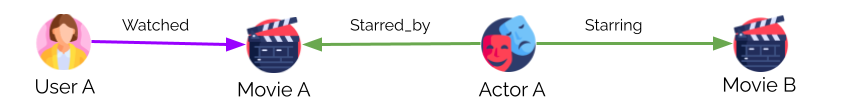

Антипримеры: 

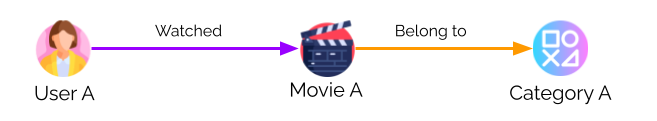

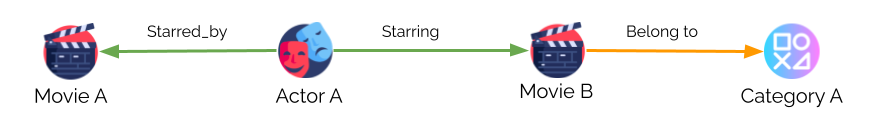

### TransE Embedding

TransE - это эмбеддиг (translational knowledge hraph embedding KGE). 

Margin Loss:

$$L(h, r, t) = max(0, f_{r}(h, t)_{pos} - f_{r}(h, t)_{neg} + margin)$$


$$h + r \sim t$$

$$f_{r}(h, t) = || h + r - t||$$

Источник - https://www.ga-ccri.com/use-transe-effectively

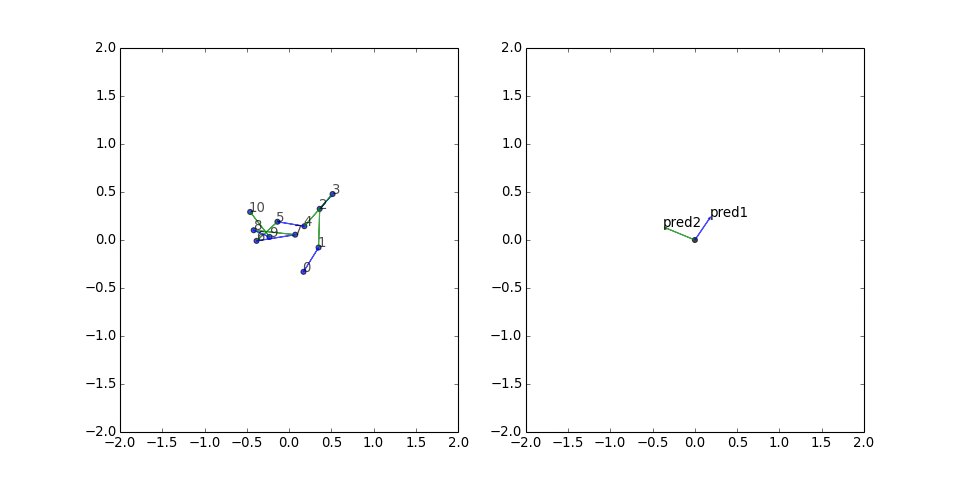

По факту, используется две разные скоринговые функции. 
* **Multi-hop scoring**.
* **Reward function** 

### Policy Guided Path Reasoning (PGPR)

PGRP - Self-Explainable recommendation на основе RL обучения. 

Для постановки RL задач, нужно определить 4 вещи:

- `Enviroment`: среда - это сам KG граф
- `Set of States`: вершины KG
- `Set of Actions`: ребра KG
- `Reward`: считается с помощью TransE эмбеддингов

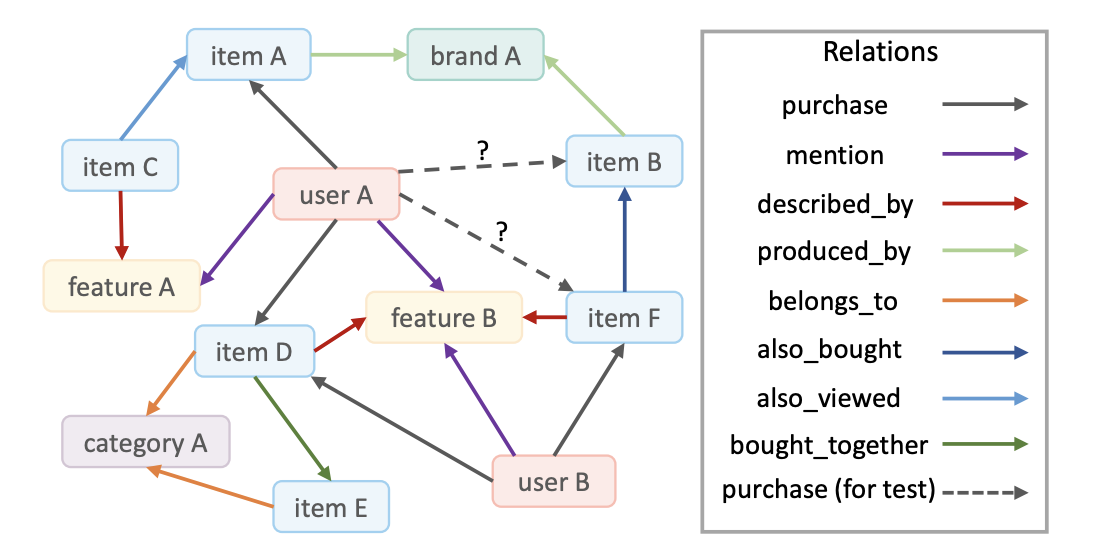

 

Multi-hop скоринговая функция для пути длины k определен как сумма скалярного произведения в translation пространстве между сущностями, которые составляют путь. 

В частности, рассмотрим путь (e<sub>0</sub>, r<sub>0</sub> e<sub>i</sub>, r<sub>k-1</sub>, e<sub>k-1</sub>, r<sub>k</sub> e<sub>k</sub>):

**Multi-hop scoring function**: $ f(e_0, e_k) = \sum_{i=0}^{k} < e_i, e_{i+1} > $


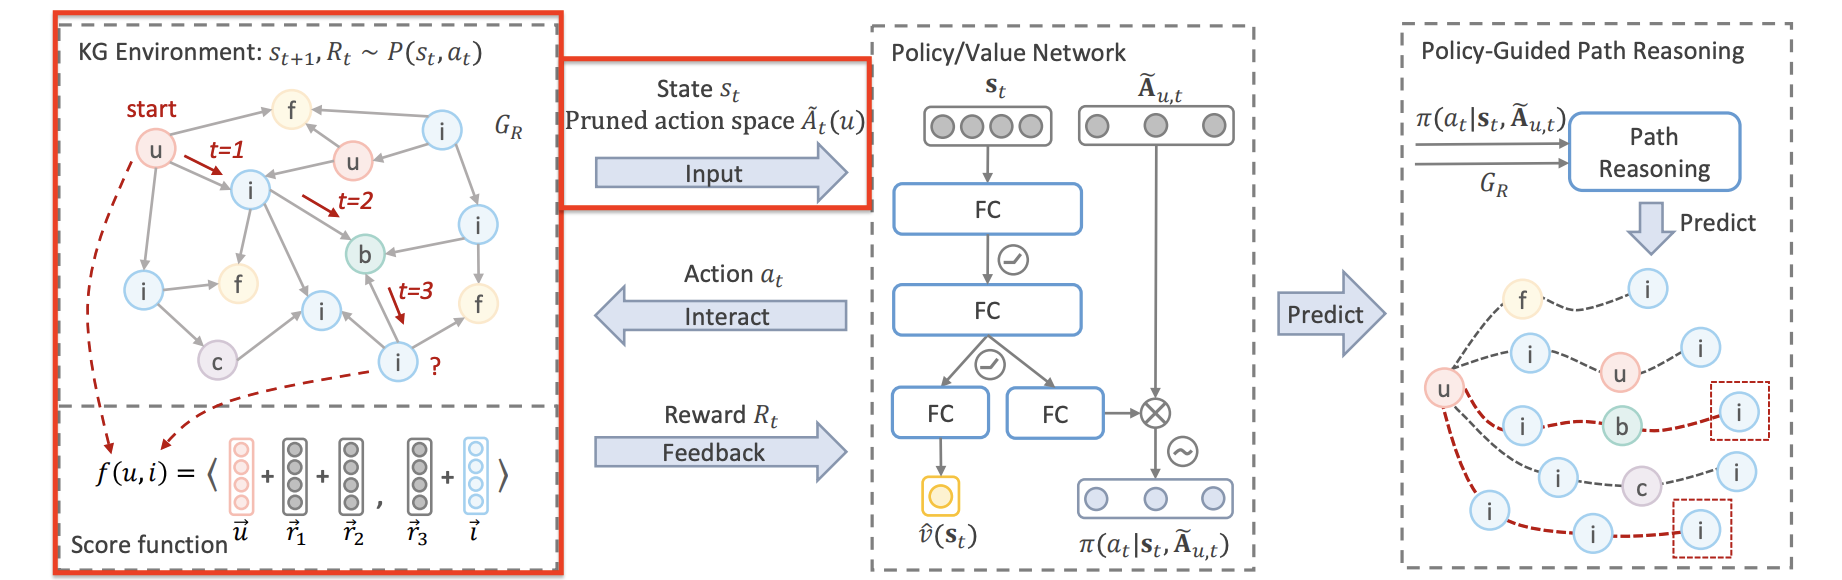



**Reward function**: $R_t = \{ <e_0, e_k> | \; e_0 \in U, \; e_k \in P\}$

Сделаем train-test split с time-based user-based разделением. 

In [28]:
from mapper import write_time_based_train_test_split

Параметры кастомной функции `write_time_based_train_test_split` на вход:
- `dataset_name`
- `model_name`: `{pgpr, cafe}`
- `train_size`
- `valid_size=0`

In [29]:
dataset_name = "ml1m"
write_time_based_train_test_split(dataset_name, "pgpr", 0.8)

Вернем в формате `uid, pid, 1, timestamp`. 

In [ ]:
with gzip.open("data/ml1m/preprocessed/pgpr/train.txt.gz", 'rt') as train_file:
    for i, line in enumerate(train_file):
        if i > 5: break
        print(line)
train_file.close()

Подготовим Dataloader

In [ ]:
from mapper import map_to_PGPR

map_to_PGPR(dataset_name)
#%ls data/{dataset_name}/preprocessed/pgpr

Внутри, функция `map_to_PGPR` будет выделять сущности из KG и группировать все сущности и отношения по их типу. По итогу, у нас будет два файла:
- С сущностями
- С отношениями

### 2.1.3 Run PGPR preprocessing

In [ ]:
%cd models/PGPR

%run preprocess.py --dataset {dataset_name}

! ls ../../data/{dataset_name}/preprocessed/pgpr/tmp

### 2.2 Train TransE Embedding

The transE hyperparameter list is reported as follow:
- `--epochs`: number of epochs to train.
- `--batch_size`: batch size.
- `--lr`: learning rate
- `--weight_decay`: weight decay for adam.
- `--l2_lambda`: l2 normalization
- `--max_grad_norm`: clipping gradient
- `--embed_size`: knowledge embedding size.
- `--num_neg_samples`: number of negative samples.

For simplicity, we have already set the values so we can just run the script indicating the `dataset_name`. 

⚠️ У нас уже есть заранее предрасчитанные **transE**, поэтому можно не запускать ячейку с кодом. Файл  `transe_model_sd_epoch_30.ckpt` лежит в `data/{dataset_name}/preprocessed/pgpr/tmp/train_transe_model`

⏲️ Время выполнения: примерно 1час.

In [ ]:
# %run train_transe_model --dataset {dataset_name}
# ! ls ../../data/{dataset_name}/preprocessed/pgpr/tmp/train_transe_model

### 3 - Train Agent

Понятно ли, какая у нас основная цель обучения?

Какие шаги нужно выполнятьЮ


> **Multi-hop scoring function**: $ f(e_0, e_k) = \sum_{i=0}^{k} < e_i, e_{i+1} > $

> **Reward function**: $R_t = \{ <e_0, e_k> | \; e_0 \in U, \; e_k \in P\}$

Политика $\pi$ будет хранить скор вероятности принятия действий $а_t$ (ребро) с учетом текущего состояния $s_t$ в момент времени t и пространстве действий $A_{s_t, s_t+ 1}$

Гиперпараметры во время обучения:

- `--epochs`: Max number of epochs.
- `--batch_size`: Batch size.
- `--lr`: Learning rate.
- `--max_acts`: Max number of actions.
- `--max_path_len`: Max path length.
- `--gamma`: reward discount factor.
- `--ent_weight`: weight factor for entropy loss.
- `--act_dropout`: action dropout rate.
- `--state_history`: state history length.
- `--hidden`: Number of samples.


⚠️ В есть предрасчитанные политики. Можно взять `policy_model_epoch50.pkl` файл по пути `data/{dataset_name}/preprocessed/pgpr/tmp/train_agent`

⏲️ Время расчета: примерно 20 минут.

## 4 Extract paths from policy

Остается только вытащить пути из ранее обученной политики $\pi$, при
 $\pi(a_t | s_t, A_{u,t})$.

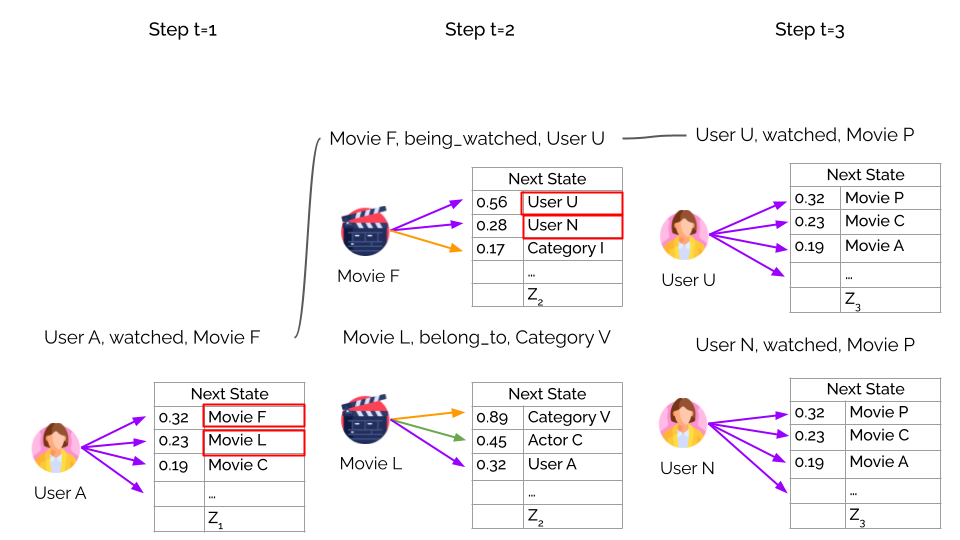

Гиперпараметры для тестового агента с имплементацией beam search: 

- `--epochs`: Max number of epochs.
- `--max_acts`: Max number of actions.
- `--max_path_len`: Max path length.
- `--gamma`: reward discount factor.
- `--hidden`: Number of samples.
- `--act_dropout`: Action dropout rate.
- `--state_history`: State history length.
- `--topk`: number of samples for the batch beam search. (e.g. [Z1, Z2, Z3])
- `--run_path`: Generate predicted path? (takes long time)
- `--run_eval`: Run evaluation?

⚠️  В репозитории лежат предрасчитанные пути из политики. Файл `policy_paths_epoch50.pkl` по пути `data/{dataset_name}/preprocessed/pgpr/tmp/train_agent`

⏲️ Время расчета: примерно 25 мин.

In [ ]:
# %run test_agent --dataset {dataset_name}

## CAFE

Основная разница - в методологии. 

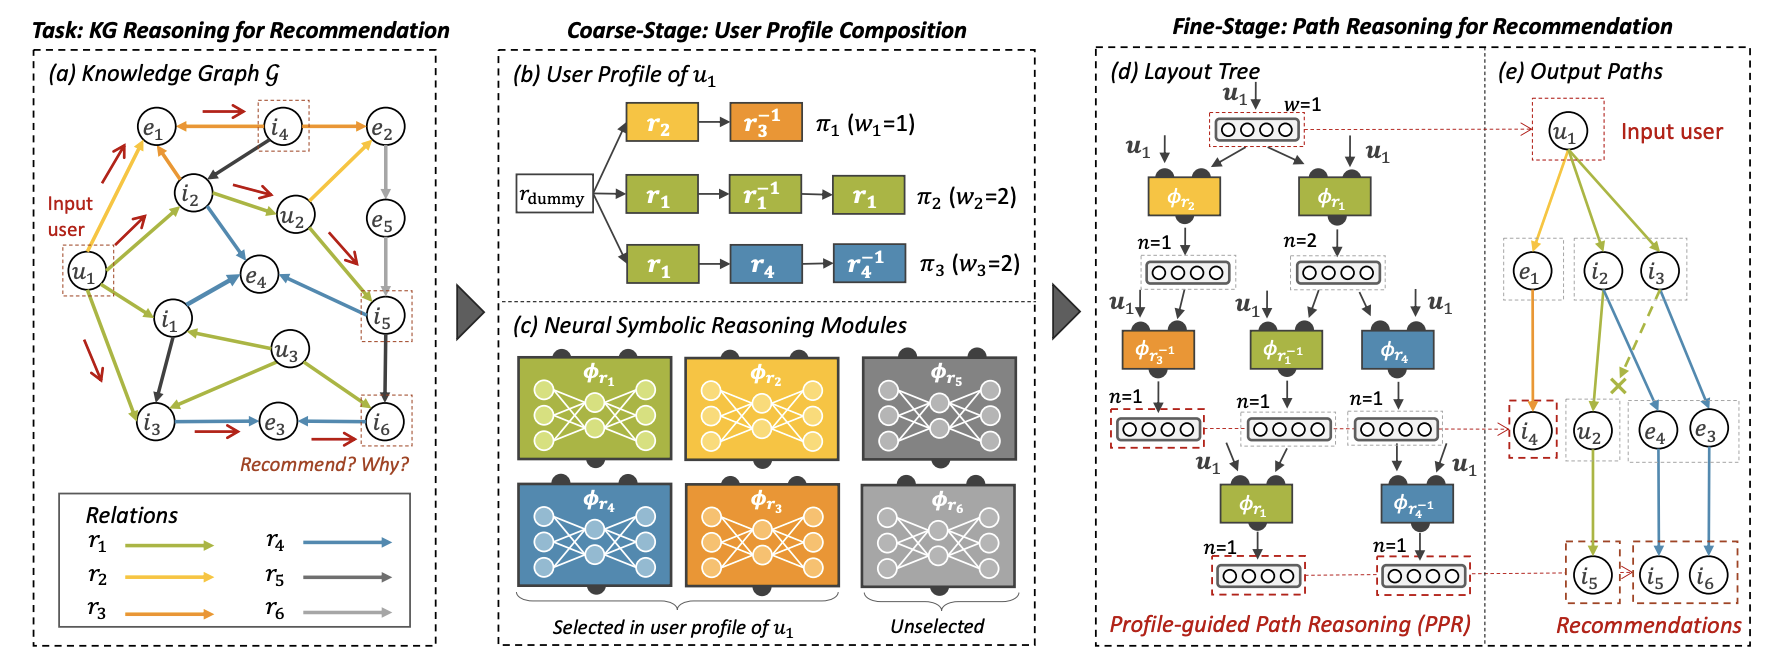

In [ ]:
dataset_name = "ml1m"
dir_ = "/home/m.ananyeva/recsys_course/week7"
transe_pgpr_path = dir_ + f"/data/{dataset_name}/preprocessed/pgpr/tmp/train_transe_model/transe_model_sd_epoch_30.ckpt"
transe_cafe_path = dir_ + f"/data/{dataset_name}/preprocessed/cafe/kg_embedding.ckpt"
shutil.copyfile(transe_pgpr_path,
                transe_cafe_path)

In [ ]:
from mapper import map_to_CAFE

map_to_CAFE(dataset_name, 0.8)
#%ls data/{dataset_name}/preprocessed/cafe 

### Preprocessing

Есть предрассчитанный файл 

⏲️ Время расчета: примерно 1 час

In [ ]:
%cd models/CAFE
%run preprocess.py --dataset {dataset_name}
%ls ../../data/{dataset_name}/preprocessed/cafe/tmp

### Train Neural Symbol

Две основные фазы:
- обучение профилей пользователей (в дальнейшем для поиска)
- обучение Neural Symbolic Reasoning Modules

Два шага:

1) Random walk алгоритм даст множество < юзер-центричных паттернов. 

2) Потом, выбираем подмножество  $\Pi$  и назначаем веса которые отражают поведение для каждого пользователя. 

Объяснение пути основывается на одношаговой процедуре - reasoner $\phi$. Он определяет действие на $t$ шаге через оценку вероятности $P_{\Theta}(r_t, e_t | u, h_t)$  выбора исходящего ребра $(r_t, e_t)$ для данного пользователя и траектории $h_t = \{r_1, e_1, \dots, r_{t-1}, e_{t-1}\}$. 

Запуск скрипта для выучивания политики `train_neural_symbolic.py`

Гиперпараметры для train: 
- `--epochs`: Max number of epochs.
- `--batch_size`: Batch size.
- `--lr`: Learning rate.
- `--deep_module`: Use deep module or not.
- `--embed_size`: KG embedding size.
- `use_dropout`: use dropout or not.
- `rank_weight`: weighting factor for ranking loss.
- `topk_candidates`: weighting factor for ranking loss.

Время выполнения ячейки: примерно 20 мин

In [ ]:
# %run train_neural_symbol.py --dataset {dataset_name}
# %ls ../../data/{dataset_name}/preprocessed/cafe/tmp/

## 4 Extract paths 

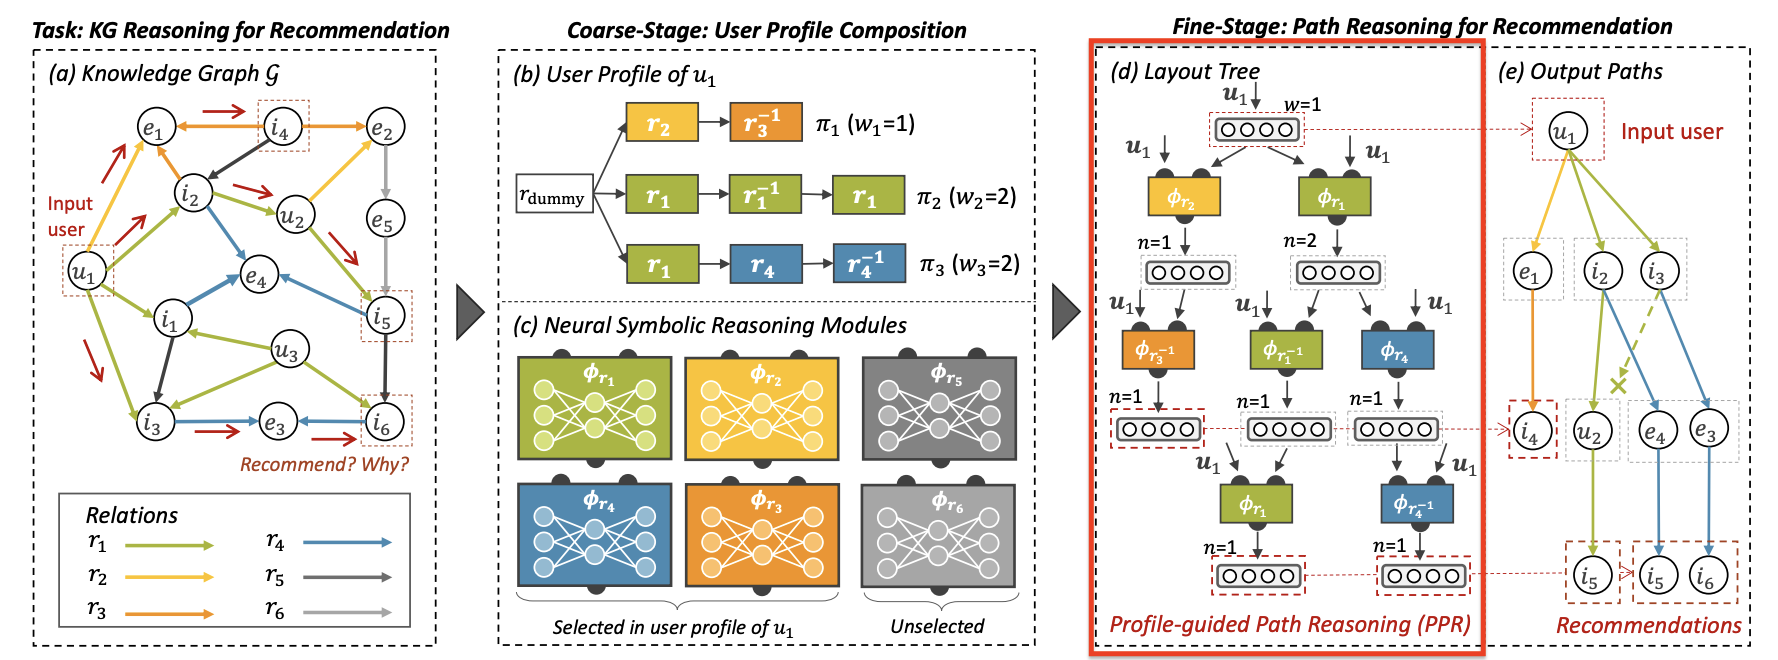

Извлекаем пути из политики (скрипт `execute_neural_symbol.py`).

Гиперпараметры для теста:
- `--sample_size`: sample size for model.
- `--do_infer`: Whether to infer paths after training.
- `--do_execute`: Whether to execute neural programs.

Для нижней ячейки есть уже сохраненный файл - `infer_path_data.pkl`.

In [ ]:
# %run execute_neural_symbol.py --dataset {dataset_name} --do_infer True
# %ls ../../data/{dataset_name}/preprocessed/cafe/tmp/train_agent

## Textual explanation creation and evaluation 

1. Загрузим полученные пути 
2. Сгенерируем топ-k айтемов и объяснений
3. Сгенерируем текстовые объяснения через шаблон

In [ ]:
import numpy as np
import pandas as pd
from random import seed, randint, choice
from collections import defaultdict
import pickle

Будем хранить данные для обеих моделей, чтобы сравнить их потом. 

In [ ]:
train_labels = {}
test_labels = {}

users_topk = {model: defaultdict(list) for model in models}

И посчитаем метрики качества рекомендаций

In [ ]:
ndcgs = {model: [] for model in models}
recalls = {model: [] for model in models}
precisions = {model: [] for model in models}

In [ ]:
def dcg_at_k(topk, k, method=1):
    topk = np.asfarray(topk)[:k]
    if topk.size:
        if method == 0:
            return topk[0] + np.sum(topk[1:] / np.log2(np.arange(2, topk.size + 1)))
        elif method == 1:
            return np.sum(topk / np.log2(np.arange(2, topk.size + 2)))
        else:
            raise ValueError('method must be 0 or 1.')
    return 0.

def ndcg_at_k(topk, k, method=1):
    dcg_max = dcg_at_k(sorted(topk, reverse=True), k, method)
    if not dcg_max:
        return 0.
    return dcg_at_k(topk, k, method) / dcg_max

def recall_at_k(topk, test_pids):
    return sum(topk) / len(test_pids)
    
def precision_at_k(topk, k):
    return sum(topk) / k

Размапим id айтемов в текст

In [ ]:
from knowledge_graph_utils import entity2plain_text

entity2name = {}
entity2name["cafe"] = entity2plain_text(dataset_name, "cafe")
entity2name["pgpr"] = entity2plain_text(dataset_name, "pgpr")

def path_len(path):
    len = 0
    for s in path:
        if type(s) != str:
            s = str(s)
        if s.isnumeric():
            len+=1
    return len


def template(curr_model, path):
    if path[0] == "self_loop":
        path = path[1:]

    path_length = path_len(path)
    for i in range(1, len(path)):
        s = str(path[i])
        if s.isnumeric():
            if path[i-1] == 'user': continue
            if int(path[i]) not in entity2name[curr_model][path[i-1]]: continue
            path[i] = entity2name[curr_model][path[i-1]][int(path[i])]
    if path_length == 4:
        _, uid, rel_0, e_type_1, e_1, rel_1, e_type_2, e_2, rel_k, _, pid  = path
        return f"{pid} is recommend to you because you {rel_0} {e_1} also {rel_k} by {e_2}"
    elif path_len(path) == 3:
        _, uid, rel_0, e_type_1, e_1, rel_1, _, pid  = path
        return f"{pid} is recommend to you because is {r_k} with {e_1} that you previously {rel_0}"

## PGPR

### 1. Path loading

In [ ]:
curr_model = "pgpr"

with open(f"results/{dataset_name}/{curr_model}/pred_paths.pkl", 'rb') as pred_paths_file:
    pred_paths_pgpr = pickle.load(pred_paths_file)
pred_paths_file.close()

pd.DataFrame(pred_paths_pgpr[:10], columns=["uid", "pid", "path_score", "path_probability", "path"])

Сгруппируем пути по uid и положим в словарь. Первый ключ - uid, второй - pid, чтобы хранить все пути uid-pid. 

In [ ]:
header = ["uid", "pid", "path_score", "path_prob", "path"]
pred_paths_map_pgpr = defaultdict(dict)
for record in pred_paths_pgpr:
    uid, pid, path_score, path_prob, path = record
    if pid not in pred_paths_map_pgpr[uid]:
        pred_paths_map_pgpr[uid][pid] = []
    pred_paths_map_pgpr[uid][pid].append((float(path_score), float(path_prob), path))

Посчитаем для случайного пользователя и случайного айтема

In [ ]:
n_users = len(pred_paths_map_pgpr.keys())
random_user = randint(0, n_users)
random_product = choice(list(pred_paths_map_pgpr[random_user].keys()))
print(pred_paths_map_pgpr[random_user][random_product])

Можно заметить, что в PGPR могут существовать разны пути между пользователем и айтемом. Поскольку в конце мы можем сгенерить объяснение любой рекомендации, мы выбираем путь с наибольшей вероятностью как финальное объяснение. 

### 2. Top-N generation

Дополнительно фромильтруем уже показанные ранее фильмы пользователю.

Создадим словарик, где ключи - uid, значения - список предсказанных путей для него. Для каждых uid-pid, если есть несколько путей, будем добавлять в список только путь с наибольшим скором.

In [ ]:
from pgpr_utils import load_labels

train_labels[curr_model] = load_labels(dataset_name, 'train')
test_labels[curr_model] = load_labels(dataset_name, 'test')

%cd /home/m.ananyeva/recsys_course/week7

best_pred_paths = {}
for uid in pred_paths_map_pgpr:
    if uid in train_labels[curr_model]:
        train_pids = set(train_labels[curr_model][uid])
    else:
        print("Invalid train_pids")
    best_pred_paths[uid] = []
    for pid in pred_paths_map_pgpr[uid]:
        if pid in train_pids:
            continue
        # Get the path with highest probability
        sorted_path = sorted(pred_paths_map_pgpr[uid][pid], key=lambda x: x[1], reverse=True)
        best_pred_paths[uid].append(sorted_path[0])

Посмотрим на результат на случайном пользователе

In [ ]:
random_user = randint(0, n_users)
best_pred_paths[random_user][:5]

Посчитаем top-k с отсечением по порогу 10. Обратите внимание, что в PGPR можно выбрать несколько порогов, в то время как в CAFE размер top-k задается на этапе обучения.

In [ ]:
n=10

for uid in range(len(best_pred_paths.keys())):
    sorted_paths = sorted(best_pred_paths[uid], key=lambda x: (x[0], x[1]), reverse=True)
    sorted_paths = [[path[0], path[1], path[-1].split(" ")] for path in sorted_paths]
    topk_products = [int(path[-1][-1]) for path in sorted_paths[:n]]
    topk_explanations = [path[-1] for path in sorted_paths[:n]]
    users_topk[curr_model][uid] = list(zip(topk_products, topk_explanations))
    
random_user = randint(0, n_users)
users_topk[curr_model][random_user][0]

### 2.3 Evaluation

In [ ]:
for uid, rec_exp_tuples in users_topk[curr_model].items():
    hits = []
    for rec_exp_tuple in rec_exp_tuples:
        recommended_pid = rec_exp_tuple[0]
        if recommended_pid in test_labels[curr_model][uid]:
            hits.append(1)
        else:
            hits.append(0)
    while len(hits) < 10:
        hits.append(0)
    ndcg = ndcg_at_k(hits, n)
    precision = precision_at_k(hits, n)
    recall = recall_at_k(hits, test_labels[curr_model][uid])
    ndcgs[curr_model].append(ndcg)
    precisions[curr_model].append(precision)
    recalls[curr_model].append(recall)
print(f"Overall NDGC: {np.mean(ndcgs[curr_model])}, Precision: {np.mean(precisions[curr_model])}, Recall: {np.mean(recalls[curr_model])}")

### 2.4 - Textual Explanation generation

In [ ]:
random_user = randint(0, len(users_topk[curr_model].keys()))
for i, pid_exp_tuple in enumerate(users_topk[curr_model][random_user]):
    pid, exp = pid_exp_tuple[0], pid_exp_tuple[1]
    users_topk[curr_model][random_user][i] = (pid, template(curr_model, exp))

In [ ]:
pd.DataFrame(users_topk[curr_model][random_user], columns=["pid", "textual explanation"])

In [ ]:
pd.DataFrame(users_topk[curr_model][random_user], columns=["pid", "textual explanation"]).iloc[0]['textual explanation']

## 3 - Cafe

То же самое со второй моделью

In [ ]:
from cafe_utils import load_labels

curr_model = "cafe"
with open(f"results/{dataset_name}/{curr_model}/pred_paths.pkl", 'rb') as pred_paths_file:
    pred_paths = pickle.load(pred_paths_file)
pred_paths_file.close()

In [ ]:
# %cd /home/m.ananyeva/recsys_course/week7/
train_labels[curr_model] = load_labels("ml1m", 'train')
test_labels[curr_model] = load_labels("ml1m", 'test')

In [ ]:
pd.DataFrame(pred_paths[:10], columns=["uid", "pid", "path_score", "path_probability", "path"])

In [ ]:
header = ["uid", "pid", "path_score", "path_prob", "path"]
pred_paths_map_cafe = defaultdict(dict)
for record in pred_paths:
    uid, pid, path_score, path_prob, path = record
    if pid not in pred_paths_map_cafe[uid]:
        pred_paths_map_cafe[uid][pid] = []
    pred_paths_map_cafe[uid][pid].append((path_score, path_prob, path))

In [ ]:
n_users = len(pred_paths_map_cafe.keys())
random_user = randint(0, n_users)
random_product = choice(list(pred_paths_map_cafe[random_user].keys()))
print(pred_paths_map_cafe[random_user][random_product])ь

### 3.2 Top-N

In [ ]:
n = 10
for uid, pids in pred_paths_map_cafe.items():
    user_paths = []
    for paths in pids.values():
        user_paths.extend(paths)
    sorted(user_paths, key=lambda x: x[0], reverse=True)
    users_topk[curr_model][uid] = [(path[-1][-1], path[-1]) for path in user_paths[:n]]

### 3.3 Evaluation

In [ ]:
for uid, rec_exp_tuples in users_topk[curr_model].items():
    hits = []
    for rec_exp_tuple in rec_exp_tuples:
        recommended_pid = rec_exp_tuple[0]
        if recommended_pid in test_labels[curr_model][uid]:
            hits.append(1)
        else:
            hits.append(0)
    while len(hits) < 10:
        hits.append(0)
    ndcg = ndcg_at_k(hits, n)
    precision = precision_at_k(hits, n)
    recall = recall_at_k(hits, test_labels[curr_model][uid])
    ndcgs[curr_model].append(ndcg)
    precisions[curr_model].append(precision)
    recalls[curr_model].append(recall)
print(f"Overall NDGC: {np.mean(ndcgs[curr_model])}, Precision: {np.mean(precisions[curr_model])}, Recall: {np.mean(recalls[curr_model])}")

### 3.4 - Textual explanation generation

In [ ]:
random_user = randint(0, len(users_topk[curr_model].keys()))
for i, pid_exp_tuple in enumerate(users_topk[curr_model][random_user]):
    pid, exp = pid_exp_tuple[0], pid_exp_tuple[1]
    users_topk[curr_model][random_user][i] = [pid, template(curr_model, exp)]

In [ ]:
users_topk[curr_model][random_user][i]

In [ ]:
pd.DataFrame(users_topk[curr_model][random_user], columns=["pid", "textual explanation"])

## 4 - Path Reasoning Quality

Метрики для оценки качества:

- The **Recency (R)** of the **Linking Interaction**.
- The **Popularity (P)** of the **Shared Entity**.
- The **Diversity (D)** of the **Path Type** in a group of explanations.

Значения всех метрик - [0, 1]

Эти метрики могут быть адоптированы и добавлены в функции потерь (multi-hop scoring function, reward function) в PGPR. 

Результаты ниже показывают, что при добавлении их в модель, мы получеам меньше side-effects (побочных эффектов) в метриках, меньшее снижение NDCG. А кобминирование post-processing + добавление в обучение дает лучшие результаты и для качества объяснений рекомендаций и эффективность самих рекомендаций. 

![Copia di [22KBE]case-study-plots.png](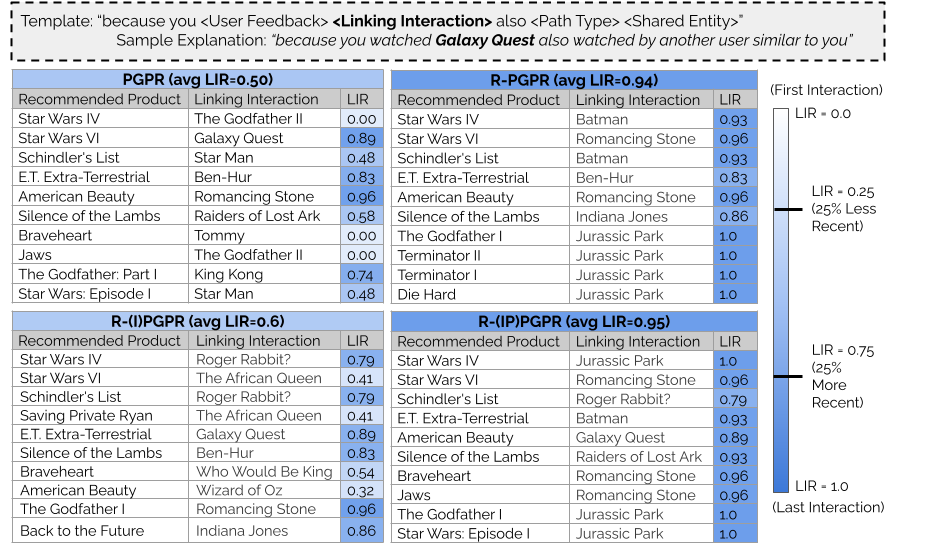)

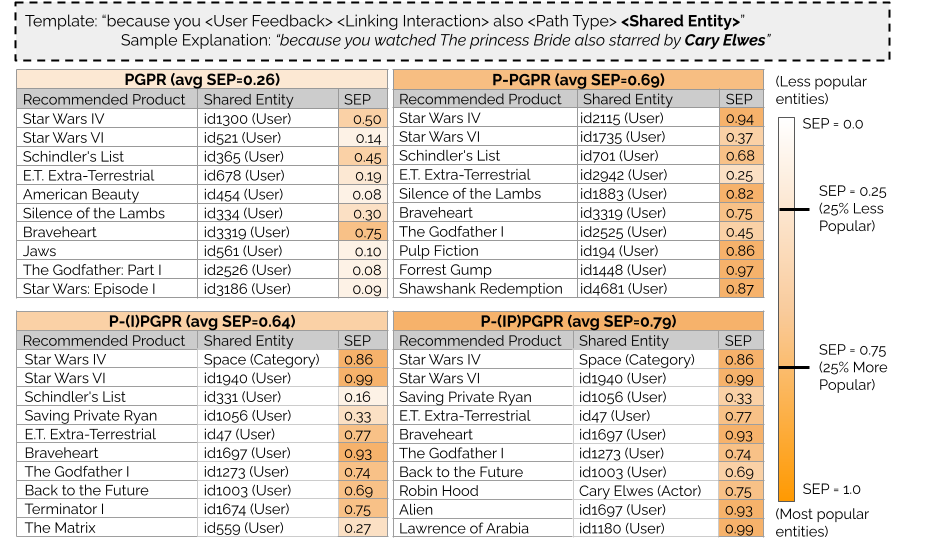

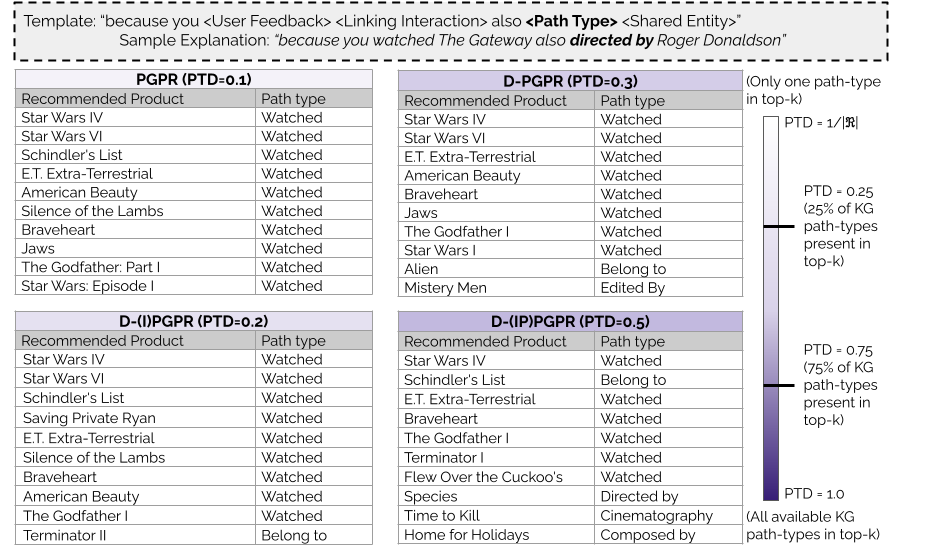

Источники:
1. [Tutorial Hands on Explainable Recommender Systems with Knowledge Graphs. RecSys 2022.](https://explainablerecsys.github.io/recsys2022/)

2. Yikun Xian, Zuohui Fu, S. Muthukrishnan, Gerard de Melo, Yongfeng Zhang: Reinforcement Knowledge Graph Reasoning for Explainable Recommendation. SIGIR 2019: 285-294

3. Yikun Xian, Zuohui Fu, Handong Zhao, Yingqiang Ge, Xu Chen, Qiaoying Huang, Shijie Geng, Zhou Qin, Gerard de Melo, S. Muthukrishnan, Yongfeng Zhang: CAFE: Coarse-to-Fine Neural Symbolic Reasoning for Explainable Recommendation. CIKM 2020: 1645-1654